<a href="https://colab.research.google.com/github/Ruanvans/GAN-time-series-implementation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following code will serve as the GAN network employed in my disseratation**

**Ruan van Schalkwyk**                                                            
**6459265**

**Supervisor: Yoachu Jin** 

**University of Surrey Computer Science** 


# **Necessary libraries and tools**

In [0]:
from google.colab import files
import pandas as pd
import requests 
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib import style

# **Data Collection**

The below cells of code are used to retrieve the data used within the project from the AlphaVantage API. The first cell works directly with the API and the second cell is used to format the data into the correct format (csv file) and then downloads the data so that it can be cleaned for further use

In [0]:
Key = 'WS42XHAOBGP40QEM'
sym= 'AAPL'

fname = 'daily' + sym +'.csv'

if not os.path.isfile(fname):
  v = urllib.request.urlopen("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + sym + "&apikey=" + Key + "&outputsize=full&datatype=csv").read()
  with open(fname, 'wb') as f:
    f.write(v)

In [0]:
df = pd.read_csv(fname)

df = pd.DataFrame(df)

df.to_csv('Apple.csv')
files.download('Apple.csv')

df

,timestamp,open,high,low,close,volume
0,2020-05-11,308.10,317.05,307.24,315.01,36486561
1,2020-05-08,305.64,310.35,304.29,310.13,33511985
2,2020-05-07,303.22,305.17,301.97,303.74,28803764
3,2020-05-06,300.46,303.24,298.87,300.63,35583438
4,2020-05-05,295.06,301.00,294.46,297.56,36937795
...,...,...,...,...,...,...
5027,2000-05-16,104.52,109.06,102.75,105.69,3932600
5028,2000-05-15,108.06,108.06,100.12,101.00,6061900
5029,2000-05-12,106.00,110.50,104.77,107.62,2740300
5030,2000-05-11,101.37,104.25,99.00,102.81,4462000


# **Data preprocessign**

Below cell provides convenience when uploading the data as it is faster to upload a zip file with all the cleaned data to google colab than to upload individual files. 

In [6]:
!unzip 'final_data.zip'

Archive:  final_data.zip
  inflating: boeing.csv              
  inflating: Intercontinental.csv    
  inflating: JPMorgan.csv            
  inflating: Microsoft.csv           
  inflating: pfizer.csv              


importation of the data from the cleaned csv files

In [0]:
intercontinental = pd.read_csv('Intercontinental.csv', parse_dates=True, index_col=0)
boeing = pd.read_csv('boeing.csv', parse_dates=True, index_col=0)
jpmorgan = pd.read_csv('JPMorgan.csv', parse_dates=True, index_col=0)
microsoft = pd.read_csv('Microsoft.csv', parse_dates=True, index_col=0)
pfizer = pd.read_csv('pfizer.csv', parse_dates=True, index_col=0)

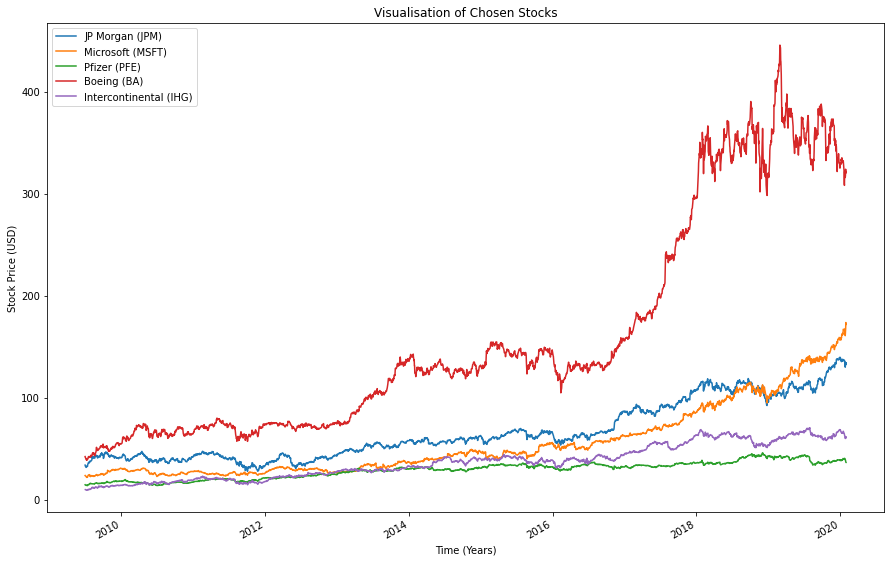

In [16]:
Intercontinental = intercontinental['open']
Boeing = boeing['open']
JPmorgan = jpmorgan['open']
Microsoft = microsoft['open']
Pfizer = pfizer['open']

plt.figure(figsize=(15,10))
JPmorgan.plot(label = 'JP Morgan (JPM)')
Microsoft.plot(label = 'Microsoft (MSFT)')
Pfizer.plot(label = 'Pfizer (PFE)')
Boeing.plot(label= 'Boeing (BA)')
Intercontinental.plot(label = 'Intercontinental (IHG)')
plt.title(label = 'Visualisation of Chosen Stocks')
plt.legend(loc='upper left')
plt.ylabel(ylabel= 'Stock Price (USD)')
plt.xlabel(xlabel= 'Time (Years)')
plt.savefig('stocks.png', bbox_inches ='tight')
files.download('stocks.png')
plt.show()